In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
%matplotlib inline



In [2]:
import time
import numpy as np
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset
import os

In [3]:
from helper_evaluation import set_all_seeds, set_deterministic, compute_confusion_matrix
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix

In [4]:
RANDOM_SEED = 123
BATCH_SIZE = 64
NUM_EPOCHS = 100
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
LR = 0.1
NUM_ATTRIBUTE = 12
NUM_HIDDEN_1 = 1024
NUM_HIDDEN_2 = 1024
NUM_CLASS = 6
OUTCOME = 'genre'

In [5]:
set_all_seeds(RANDOM_SEED)
set_deterministic()

# Load Data

In [6]:
class MyDataset(Dataset):

    def __init__(self, csv_path):
    
        df = pd.read_csv(csv_path)
        
        self.x = torch.tensor(df.iloc[:, :NUM_ATTRIBUTE].values).float()
        self.y = torch.tensor(df[OUTCOME].values).long()
        
        mean = torch.mean(self.x, dim=0)
        std = torch.std(self.x, dim=0)
        self.x = (self.x - mean)/std
        #print(len(self.x))
        #print(len(self.y))

    def __getitem__(self, index):
        attributes = self.x[index]
        label = self.y[index]
        return attributes, label

    def __len__(self):
        return self.y.shape[0]

In [7]:

train_dataset = MyDataset(csv_path='class_data/60_spotify_train.csv')

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          drop_last=True,
                          shuffle=True, # want to shuffle the dataset
                          num_workers=0) # number processes/CPUs to use

valid_dataset = MyDataset(csv_path='class_data/60_spotify_valid.csv')

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=0)



test_dataset = MyDataset(csv_path='class_data/60_spotify_test.csv')

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=0)

In [8]:
for attributes, labels in train_loader:  
    print('Image batch dimensions:', attributes.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([64, 12])
Image label dimensions: torch.Size([64])


# ONE-HOT CODE

In [9]:
def to_onehot(y, num_classes):
    y_onehot = torch.FloatTensor(y.size(0), num_classes)
    y_onehot.zero_()
    tmp = y.view(-1, 1).long().to(torch.device('cpu'))
    y_onehot.scatter_(1, tmp, 1).float()
    return y_onehot

# Model

In [10]:
class MLP(torch.nn.Module):

    def __init__(self, num_features, num_hidden_1, num_hidden_2, drop_proba, num_classes):
        super().__init__()
        
        self.num_classes = num_classes
        
        self.my_network = torch.nn.Sequential(
            ### 1st hidden layer
            torch.nn.Flatten(),
            torch.nn.Linear(num_features, num_hidden_1, bias=False),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(num_hidden_1),
            torch.nn.Dropout(drop_proba),
            ### 2nd hidden layer
            torch.nn.Linear(num_hidden_1, num_hidden_2, bias=False),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(num_hidden_2),
            torch.nn.Dropout(drop_proba),
            ### Output layer
            torch.nn.Linear(num_hidden_2, num_classes)
        )
        
        '''
        ### 1st hidden layer
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
        self.linear_1.weight.detach().normal_(0.0, 0.1)
        self.linear_1.bias.detach().zero_()
        
        ### 1st hidden layer
        self.linear_2 = torch.nn.Linear(num_hidden_1, num_hidden_2)
        self.linear_2.weight.detach().normal_(0.0, 0.1)
        self.linear_2.bias.detach().zero_()

        ### Output layer
        self.linear_out = torch.nn.Linear(num_hidden_2, num_classes)
        self.linear_out.weight.detach().normal_(0.0, 0.1)
        self.linear_out.bias.detach().zero_()
        '''
        
    def forward(self, x):
        logits = self.my_network(x)
        return logits
        '''
        out = self.linear_1(x)
        out = F.relu(out)
        out = self.linear_2(out)
        out = F.relu(out)
        logits = self.linear_out(out)
        #probas = F.log_softmax(logits, dim=1)
        return logits#, probas
        '''

## Model Initialization with BatchNorm

Epoch: 001/100 | Batch 0000/0307 | Loss: 2.1577
Epoch: 001/100 | Batch 0050/0307 | Loss: 2.3813
Epoch: 001/100 | Batch 0100/0307 | Loss: 2.7652
Epoch: 001/100 | Batch 0150/0307 | Loss: 1.7653
Epoch: 001/100 | Batch 0200/0307 | Loss: 2.3305
Epoch: 001/100 | Batch 0250/0307 | Loss: 2.7695
Epoch: 001/100 | Batch 0300/0307 | Loss: 2.0901
Epoch: 001/100 | Train: 42.08% | Validation: 41.60%
Time elapsed: 0.09 min
Epoch: 002/100 | Batch 0000/0307 | Loss: 1.9635
Epoch: 002/100 | Batch 0050/0307 | Loss: 2.0810
Epoch: 002/100 | Batch 0100/0307 | Loss: 1.8415
Epoch: 002/100 | Batch 0150/0307 | Loss: 2.3511
Epoch: 002/100 | Batch 0200/0307 | Loss: 2.4504
Epoch: 002/100 | Batch 0250/0307 | Loss: 2.5133
Epoch: 002/100 | Batch 0300/0307 | Loss: 2.3615
Epoch: 002/100 | Train: 43.20% | Validation: 43.06%
Time elapsed: 0.19 min
Epoch: 003/100 | Batch 0000/0307 | Loss: 1.7595
Epoch: 003/100 | Batch 0050/0307 | Loss: 3.0299
Epoch: 003/100 | Batch 0100/0307 | Loss: 2.4510
Epoch: 003/100 | Batch 0150/0307 |

Epoch: 021/100 | Batch 0050/0307 | Loss: 1.1620
Epoch: 021/100 | Batch 0100/0307 | Loss: 1.2530
Epoch: 021/100 | Batch 0150/0307 | Loss: 1.2484
Epoch: 021/100 | Batch 0200/0307 | Loss: 1.6230
Epoch: 021/100 | Batch 0250/0307 | Loss: 1.4426
Epoch: 021/100 | Batch 0300/0307 | Loss: 1.2602
Epoch: 021/100 | Train: 53.68% | Validation: 51.83%
Time elapsed: 1.99 min
Epoch: 022/100 | Batch 0000/0307 | Loss: 1.2096
Epoch: 022/100 | Batch 0050/0307 | Loss: 1.4632
Epoch: 022/100 | Batch 0100/0307 | Loss: 1.2883
Epoch: 022/100 | Batch 0150/0307 | Loss: 1.5339
Epoch: 022/100 | Batch 0200/0307 | Loss: 1.1188
Epoch: 022/100 | Batch 0250/0307 | Loss: 1.2143
Epoch: 022/100 | Batch 0300/0307 | Loss: 1.1202
Epoch: 022/100 | Train: 53.32% | Validation: 51.22%
Time elapsed: 2.09 min
Epoch: 023/100 | Batch 0000/0307 | Loss: 1.6027
Epoch: 023/100 | Batch 0050/0307 | Loss: 1.4049
Epoch: 023/100 | Batch 0100/0307 | Loss: 1.3921
Epoch: 023/100 | Batch 0150/0307 | Loss: 1.4735
Epoch: 023/100 | Batch 0200/0307 |

Epoch: 041/100 | Batch 0050/0307 | Loss: 1.2943
Epoch: 041/100 | Batch 0100/0307 | Loss: 1.1717
Epoch: 041/100 | Batch 0150/0307 | Loss: 1.2073
Epoch: 041/100 | Batch 0200/0307 | Loss: 1.0854
Epoch: 041/100 | Batch 0250/0307 | Loss: 1.0533
Epoch: 041/100 | Batch 0300/0307 | Loss: 1.1802
Epoch: 041/100 | Train: 56.21% | Validation: 53.05%
Time elapsed: 3.80 min
Epoch: 042/100 | Batch 0000/0307 | Loss: 1.2492
Epoch: 042/100 | Batch 0050/0307 | Loss: 1.1883
Epoch: 042/100 | Batch 0100/0307 | Loss: 1.2689
Epoch: 042/100 | Batch 0150/0307 | Loss: 1.1996
Epoch: 042/100 | Batch 0200/0307 | Loss: 1.1547
Epoch: 042/100 | Batch 0250/0307 | Loss: 1.0818
Epoch: 042/100 | Batch 0300/0307 | Loss: 1.2848
Epoch: 042/100 | Train: 55.90% | Validation: 53.05%
Time elapsed: 3.89 min
Epoch: 043/100 | Batch 0000/0307 | Loss: 1.4860
Epoch: 043/100 | Batch 0050/0307 | Loss: 1.5516
Epoch: 043/100 | Batch 0100/0307 | Loss: 1.1984
Epoch: 043/100 | Batch 0150/0307 | Loss: 1.4174
Epoch: 043/100 | Batch 0200/0307 |

Epoch: 061/100 | Batch 0050/0307 | Loss: 1.3211
Epoch: 061/100 | Batch 0100/0307 | Loss: 1.2959
Epoch: 061/100 | Batch 0150/0307 | Loss: 1.2106
Epoch: 061/100 | Batch 0200/0307 | Loss: 1.0813
Epoch: 061/100 | Batch 0250/0307 | Loss: 1.1961
Epoch: 061/100 | Batch 0300/0307 | Loss: 1.2447
Epoch: 061/100 | Train: 57.18% | Validation: 53.84%
Time elapsed: 5.62 min
Epoch: 062/100 | Batch 0000/0307 | Loss: 1.0992
Epoch: 062/100 | Batch 0050/0307 | Loss: 1.1848
Epoch: 062/100 | Batch 0100/0307 | Loss: 1.2696
Epoch: 062/100 | Batch 0150/0307 | Loss: 1.0759
Epoch: 062/100 | Batch 0200/0307 | Loss: 1.1331
Epoch: 062/100 | Batch 0250/0307 | Loss: 1.1361
Epoch: 062/100 | Batch 0300/0307 | Loss: 1.1485
Epoch: 062/100 | Train: 57.06% | Validation: 53.59%
Time elapsed: 5.68 min
Epoch: 063/100 | Batch 0000/0307 | Loss: 1.2716
Epoch: 063/100 | Batch 0050/0307 | Loss: 1.2734
Epoch: 063/100 | Batch 0100/0307 | Loss: 1.0531
Epoch: 063/100 | Batch 0150/0307 | Loss: 1.3147
Epoch: 063/100 | Batch 0200/0307 |

Epoch: 081/100 | Batch 0050/0307 | Loss: 1.2835
Epoch: 081/100 | Batch 0100/0307 | Loss: 1.1755
Epoch: 081/100 | Batch 0150/0307 | Loss: 1.1888
Epoch: 081/100 | Batch 0200/0307 | Loss: 1.1134
Epoch: 081/100 | Batch 0250/0307 | Loss: 1.2271
Epoch: 081/100 | Batch 0300/0307 | Loss: 1.0178
Epoch: 081/100 | Train: 58.20% | Validation: 54.08%
Time elapsed: 7.00 min
Epoch: 082/100 | Batch 0000/0307 | Loss: 1.2307
Epoch: 082/100 | Batch 0050/0307 | Loss: 1.1455
Epoch: 082/100 | Batch 0100/0307 | Loss: 1.2794
Epoch: 082/100 | Batch 0150/0307 | Loss: 1.0751
Epoch: 082/100 | Batch 0200/0307 | Loss: 1.4053
Epoch: 082/100 | Batch 0250/0307 | Loss: 1.0093
Epoch: 082/100 | Batch 0300/0307 | Loss: 1.3045
Epoch: 082/100 | Train: 58.15% | Validation: 53.53%
Time elapsed: 7.07 min
Epoch: 083/100 | Batch 0000/0307 | Loss: 1.1705
Epoch: 083/100 | Batch 0050/0307 | Loss: 1.5433
Epoch: 083/100 | Batch 0100/0307 | Loss: 1.2329
Epoch: 083/100 | Batch 0150/0307 | Loss: 1.1888
Epoch: 083/100 | Batch 0200/0307 |

Test accuracy 53.98%


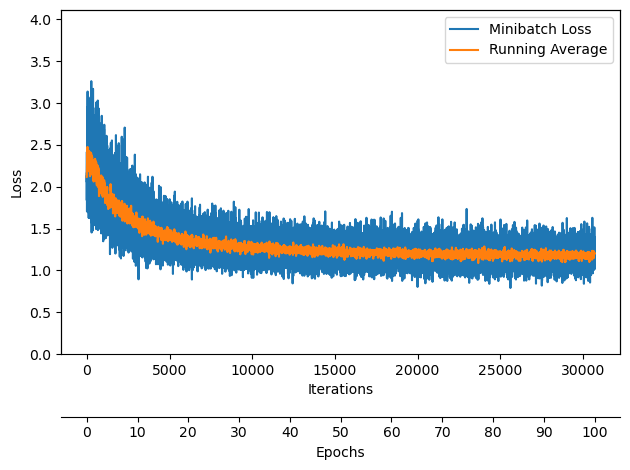

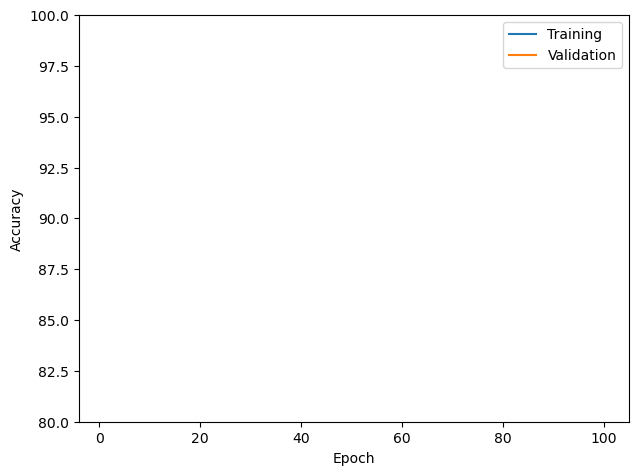

In [11]:
torch.manual_seed(RANDOM_SEED)
model = MLP(num_features=NUM_ATTRIBUTE,
                             num_hidden_1=NUM_HIDDEN_1,
                             num_hidden_2=NUM_HIDDEN_2,
                             drop_proba=0.5,
                             num_classes=NUM_CLASS)
model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=LR)

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE)

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=20)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([80, 100])
plt.show()

In [12]:
def compute_accuracy(net, data_loader):
    correct_pred, num_examples = 0, 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.view(-1, NUM_ATTRIBUTE).to(DEVICE)
            targets = targets.to(DEVICE)
            logits = net.forward(features)
            predicted_labels = torch.argmax(logits, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
        return correct_pred.float()/num_examples * 100
    
print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Training Accuracy: 58.64
Test Accuracy: 53.98


In [ ]:
class_dict = {0: 'pop',
              1: 'rap',
              2: 'rock',
              3: 'latin',
              4: 'r&b',
              5: 'edm'}

mat = compute_confusion_matrix(model=model, data_loader=test_loader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()